In [1]:
from functools import partial
from itertools import combinations, repeat

from craterdetection.matching.database import CraterDatabase, load_craters, extract_robbins_dataset, crater_representation, CoplanarInvariants
from astropy.coordinates import spherical_to_cartesian, cartesian_to_spherical
from craterdetection.common.coordinates import ENU_system, nadir_attitude
from craterdetection.common.camera import *
import craterdetection.common.constants as const

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import networkx as nx
import sklearn.neighbors

from craterdetection.matching.utils import is_clockwise, np_swap_columns, all_clockwise, is_colinear, cw_or_ccw


In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id_cat = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[4, 30])
)

In [3]:
x_cat, y_cat, z_cat = map(np.array, spherical_to_cartesian(const.RBODY, lat_cat, long_cat))

adjacency_matrix = sklearn.neighbors.radius_neighbors_graph(np.array([x_cat, y_cat, z_cat]).T, 200,
                                                                  mode='connectivity',
                                                                  metric='euclidean', n_jobs=-1)

graph = nx.from_scipy_sparse_matrix(adjacency_matrix)
crater_triads = np.array([c for c in nx.cycle_basis(graph) if len(c) == 3])

In [4]:
p_M_ijk = np.moveaxis(
    np.concatenate(
        (x_cat[crater_triads].T[None, ...],
         y_cat[crater_triads].T[None, ...],
         z_cat[crater_triads].T[None, ...]),
        axis=0
    ),
    0, 2)[..., None]
p_centroid = np.mean(p_M_ijk, axis=0)

In [5]:
# VIRTUAL CAMERA
alt = 300
p_vcam = p_centroid + (p_centroid/LA.norm(p_centroid, axis=1)[..., None])*alt

X_ax_cam, Y_ax_cam, Z_ax_cam = nadir_attitude(p_vcam)
T_CM = np.concatenate((X_ax_cam, Y_ax_cam, Z_ax_cam), axis=-1)
if (LA.matrix_rank(T_CM) != 3).any():
    raise Warning("Invalid camera attitude matrices present!:\n", T_CM)

In [6]:
K = camera_matrix()
T_MC = LA.inv(T_CM)
P_MC = K @ T_MC @ np.concatenate((np.tile(np.identity(3), (len(p_vcam), 1, 1)), -p_vcam), axis=2)

array([[1.20710678e+03, 0.00000000e+00, 5.00000000e+02],
       [0.00000000e+00, 1.20710678e+03, 5.00000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [7]:
C_cat = crater_representation(major_cat, minor_cat, psi_cat)
H_C_triads = np.array(list(map(crater_camera_homography, p_M_ijk, repeat(P_MC))))
r_triads_image = np.array(list(map(lambda T: (T @ np.array([0, 0, 1]) / (T @ np.array([0, 0, 1]))[:, -1][:, None])[:, :2], H_C_triads)))

In [8]:
x_triads = r_triads_image[..., 0]
y_triads = r_triads_image[..., 1]
clockwise = is_clockwise(x_triads, y_triads)

crater_triads_cw = crater_triads.copy()
crater_triads_cw[~clockwise] = np_swap_columns(crater_triads[~clockwise])
x_triads[:, ~clockwise] = np_swap_columns(x_triads.T[~clockwise]).T
y_triads[:, ~clockwise] = np_swap_columns(y_triads.T[~clockwise]).T
H_C_triads[[0, 1], np.argwhere(~clockwise)] = H_C_triads[[1, 0], np.argwhere(~clockwise)]

if not all_clockwise(x_triads, y_triads):
    line = is_colinear(x_triads, y_triads)
    x_triads = x_triads[:, ~line]
    y_triads = y_triads[:, ~line]
    crater_triads_cw = crater_triads_cw[~line]
    H_C_triads = H_C_triads[:, ~line]

    if not all_clockwise(x_triads, y_triads):
        raise RuntimeError("Failed to order triads in clockwise order.")

In [10]:
np.logical_and.reduce(cw_or_ccw(x_triads, y_triads) < 0)

True

In [11]:
C_triads = np.array(list(map(lambda vertex: C_cat[vertex], crater_triads_cw.T)))
A_i, A_j, A_k = map(lambda T, A: LA.inv(T).transpose((0, 2, 1)) @ A @ LA.inv(T), H_C_triads, C_triads)

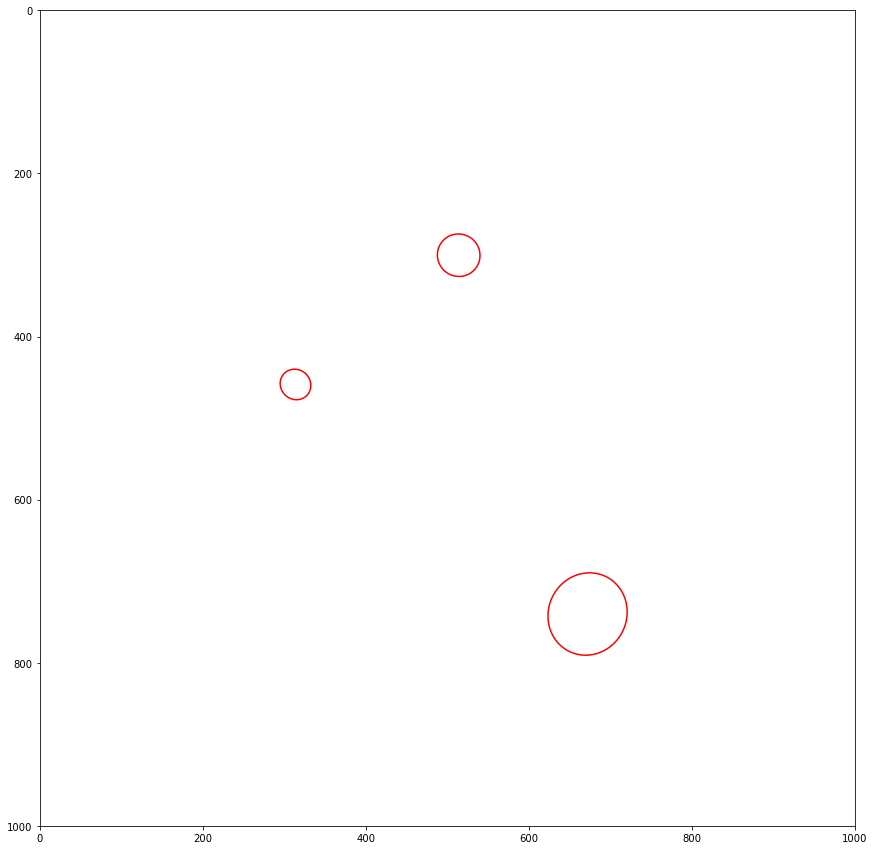

In [12]:
x_plot = np.linspace(0, const.CAMERA_RESOLUTION[0], 500)
y_plot = np.linspace(0, const.CAMERA_RESOLUTION[1], 500)
x_plot, y_plot = np.meshgrid(x_plot, y_plot)

xy_homogeneous = np.concatenate(
    (
        x_plot.ravel()[None, :],
        y_plot.ravel()[None, :],
        np.ones_like(x_plot.ravel()[None, :])
    ),
    axis=0
).T[..., None]

# c = xy_homogeneous.transpose(0, 2, 1) @ A_i[:, None, ...] @ xy_homogeneous
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'aspect': 'equal'})
# Set axes according to camera pixel space convention
ax.set_xlim(0, const.CAMERA_RESOLUTION[0])
ax.set_ylim(const.CAMERA_RESOLUTION[1], 0)
i = 789456
for a_i in [A_i[i], A_j[i], A_k[i]]:
    c = xy_homogeneous.transpose(0, 2, 1) @ a_i @ xy_homogeneous
    ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors='r')

array([[ -132.34158199,  -206.46862742,  -147.6303987 ,  -322.16995808,
         -123.67867855,  -147.23605688, -1201.50747887]])